In [36]:
import numpy as np
import matplotlib.pyplot as plt
from extra_packages import OutputInterface as oi
from extra_packages import sperhical_expansion as se
import SFALinearPulse as sfa_lin
from matplotlib.colors import LogNorm
from itertools import repeat
import matplotlib as mpl

In [37]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [38]:
import multiprocessing

try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default

pool = multiprocessing.Pool(processes=cpus)

In [45]:
output = oi.OutputInterface('output_files/H2O2_2.out')
Ip = abs(output.saved_orbitals[output.HOMO][0])
kappa = np.sqrt(2*Ip)
omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential
CEP = np.pi/2
N = 2

gto_coeffs = np.array(output.output_GTOs())

/home/emil/.local/lib/python3.8/site-packages/pyshtools/shclasses/shcoeffs.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, :lmax] = _np.fliplr(mnegative)[:, :lmax]
/home/emil/.local/lib/python3.8/site-packages/pyshtools/shclasses/shcoeffs.py:2821: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, lmax:] = mpositive
/home/emil/.local/lib/python3.8/site-packages/pyshtools/shclasses/shcoeffs.py:3141: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


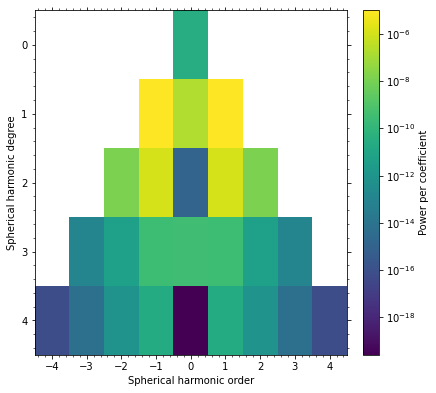

In [5]:
se.spherical_expansion(lambda theta, phi: output.eval_orbital_spherical(0.1, theta, phi), 10, plot_coeff=True)
plt.show()

In [46]:
plot_list = np.linspace(1, 10, 75)
f_lms = se.laplace_several_r(output.eval_orbital_spherical, plot_list, 10, orbital_nr=output.HOMO)

r_list = np.linspace(3.0, 3.5, 50) # 4.5 5.0, 3.0 3.5, 3.5 4.0
clm_array = se.get_asymp_fit(output.eval_orbital_spherical, r_list, 10, Ip, orbital_nr=output.HOMO,
                             threshold=1e-3, normalized=False)

# Get coefficients for other enantiomer via reflection in xy-plane: c_lm -> (-1)^(l+m)c_lm
clm_array2 = np.copy(clm_array)
for sgn in range(2):
    for l in range(clm_array.shape[1]):
        for m in range(0, l + 1):
            sign = 1.0 if sgn == 0 else -1.0
            clm_array2[sgn, l, m] *= (-1)**(l+m)

all_coeffs = np.array([np.array(gto_coeffs), np.array(clm_array)], dtype='object')

Evaluating at r=3.5000 	 Nr. 50/505
Now fitting!
Done!


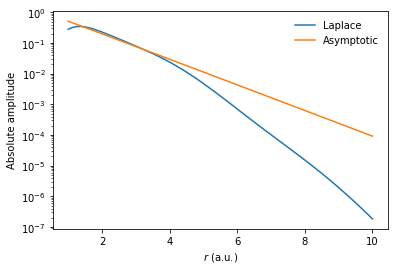

In [47]:
def asymp(r, clm):
    return clm * r**(1/kappa - 1) * np.exp(-kappa*r)

sgn, l, m = 0, 2, 1
plt.figure(facecolor='white')
plt.plot(plot_list, np.abs(f_lms[:, sgn, l, m]), label='Laplace')
plt.plot(plot_list, np.abs(asymp(plot_list, clm_array[sgn, l, m])), label='Asymptotic')
plt.xlabel('$r$ (a.u.)')
plt.ylabel('Absolute amplitude')
plt.legend(frameon=False)
plt.yscale('log')
plt.show()

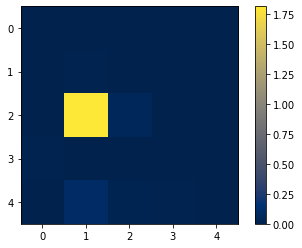

In [48]:
plt.imshow(np.abs(clm_array[0])**2, cmap='cividis')
plt.colorbar()
plt.show()

## Let us plot the HOMO and the asymptotic expansion, to see if the look alike

In [49]:
from mayavi import mlab
l = 5
n = 100
iso = 0.03
x, y, z = np.mgrid[-l:l:n*1j, -l:l:n*1j, -l:l:n*1j]
mlab.figure(1, fgcolor=(1, 1, 1), bgcolor=(1, 1, 1))
orbital = output.eval_orbital(x, y, z)

mlab.contour3d(orbital, contours=[iso], transparent=False, color=(1, 0, 0))
mlab.contour3d(orbital, contours=[-iso], transparent=False, color=(0, 0, 1))
mlab.show()

In [43]:
asymp = np.real(se.eval_asymptotic_cart(x, y, z, clm_array2, Ip))
iso = 0.02
mlab.figure(1, fgcolor=(1, 1, 1), bgcolor=(1, 1, 1))
mlab.contour3d(asymp, contours=[iso], transparent=False, color=(1, 0, 0))
mlab.contour3d(asymp, contours=[-iso], transparent=False, color=(0, 0, 1))
mlab.show()

## PMD time

In [26]:
dp = 4. / 450
px_lst = np.arange(-1, 1, dp)
pz_lst = np.arange(-1.5, 1.5, dp)
py = 0.
px_grd, pz_grd = np.meshgrid(px_lst, pz_lst)

sfa = sfa_lin.SFALinearPulse(Ip, Up, omega, N, CEP, 'asymp_martiny')
M_grd = np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array))))
M_grd2 = np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array2))))
M_sqr = np.abs(np.flip(M_grd, 0))**2
M_sqr2 = np.abs(np.flip(M_grd2, 0))**2
print('Done!')

Done!


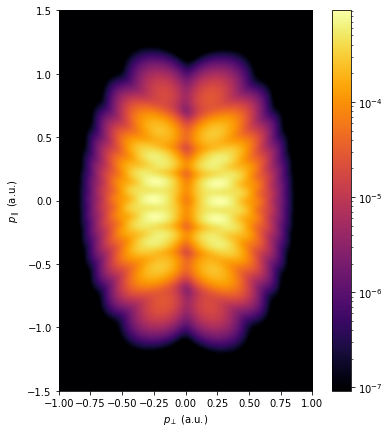

In [28]:
plt.figure(facecolor='white', figsize=(7, 7))
plt.imshow(M_sqr2, interpolation='bicubic', cmap='inferno',
                 norm=LogNorm(vmax=np.max(M_sqr2), vmin=np.max(M_sqr2)*1e-4),
                 extent=(-1, 1, -1.5, 1.5))
plt.xlabel(r'$p_\perp$ (a.u.)')
plt.ylabel(r'$p_\parallel$ (a.u.)')
plt.colorbar()
plt.show()

In [29]:
OAM_grd1 = []
OAM_grd2 = []
OAM_lst = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

dp = 4. / 250#450
px_lst = np.arange(-1, 1, dp)
pz_lst = np.arange(-1.5, 1.5, dp)
py = 0.
px_grd, pz_grd = np.meshgrid(px_lst, pz_lst)

for OAM in OAM_lst:
    print(f'Doing OAM={OAM}')
    sfa.OAM = OAM
    M_l = np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array))))
    OAM_grd1.append(M_l)
    M_l = np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array2))))
    OAM_grd2.append(M_l)
OAM_grd_tot = [OAM_grd1, OAM_grd2]

Doing OAM=-4
Doing OAM=-3
Doing OAM=-2
Doing OAM=-1
Doing OAM=0
Doing OAM=1
Doing OAM=2
Doing OAM=3
Doing OAM=4


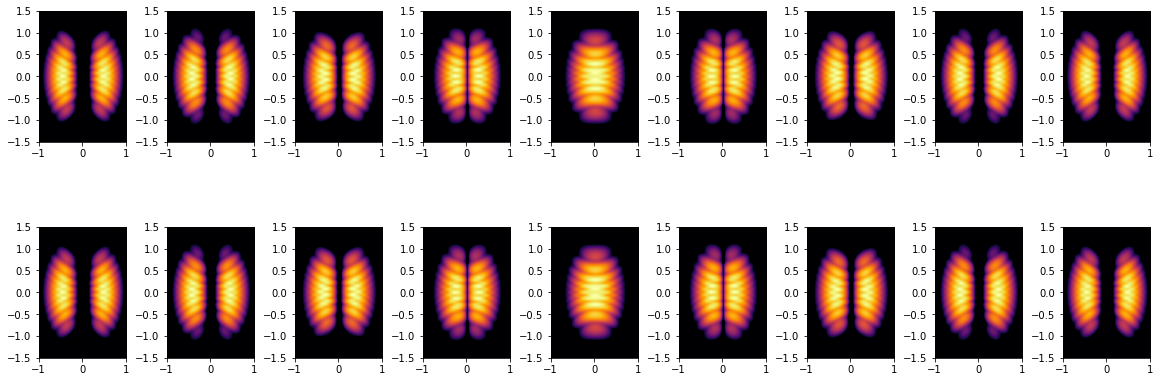

In [30]:
fig, axs = plt.subplots(2, len(OAM_lst), facecolor='white', figsize=(16, 6), constrained_layout=True)
for i in range(2):
    for j in range(len(OAM_lst)):
        axs[i, j].imshow(np.abs(OAM_grd_tot[i][j])**2, cmap='inferno', norm=LogNorm(vmax=np.max(np.abs(OAM_grd_tot[i][j])**2), vmin=np.max(np.abs(OAM_grd_tot[i][j])**2)*1e-3), extent=(-1, 1, -1.5, 1.5))
plt.show()

0.20432205061350697
0.1987351131610381
0.22440611184571008
0.1850729808668882
0.29258032445702853
0.18070369610937942
0.21858938464843236
0.1989932869390894
0.20432205061350708


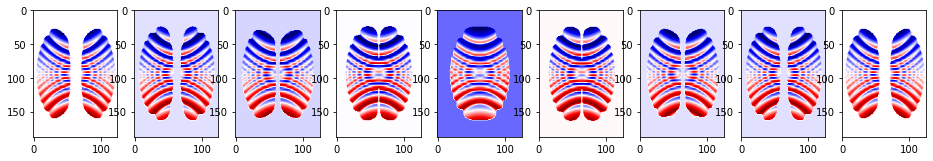

In [35]:
num = len(OAM_lst)
fig, axs = plt.subplots(1, num, facecolor='white', figsize=(16, 16))
for ax, Ml1, Ml2, l in zip(axs, OAM_grd_tot[0], OAM_grd_tot[1], OAM_lst):
    Ml1 = np.abs(Ml1)**2
    Ml2 = np.abs(Ml2)**2
    Ml2 = np.flip(Ml2, 0)
    PEVD = 2*((Ml1 - Ml2)/(Ml1 + Ml2))
    PEVD = np.nan_to_num(PEVD, nan=0)
    filter_list1 = Ml1 > np.max(Ml1*1e-3)
    filter_list2 = Ml2 > np.max(Ml2*1e-3)
    combined_filter = np.logical_or(filter_list1, filter_list2)
    PEVD[np.logical_not(combined_filter)] = 0
    ax.imshow(PEVD, cmap='seismic')#, norm=MidpointNormalize(-2, 2), extent=(-1, 1, -1.5, 1.5))
    print(np.max(PEVD))
plt.show()

In [133]:
A = np.array([[1, 2], [3, 4]])
np.flip(A, 0)

array([[3, 4],
       [1, 2]])